In [1]:
import sys
import os
import time
import shutil
import re
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision import transforms as T

from hyperparameters import *
from data_manager import rgbd_gradients_dataset, rgbd_gradients_dataloader
from functions import torch2np_u8
import plot
from plot import post_epoch_plot
from models import SpecialFuseNetModel
from data_manager import rgbd_gradients_dataset, rgbd_gradients_dataloader
from train import FuseNetTrainer

np.set_printoptions(threshold=sys.maxsize)
# %matplotlib notebook

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [3]:
CWD             = os.getcwd()
DATASET_DIR     = os.path.join(CWD,'data/nyuv2_overfit')
print(DATASET_DIR)

/home/manor/cs236781-DeepLearning/project/master/data/nyuv2_overfit


In [4]:
rgbd_grads_ds = rgbd_gradients_dataset(root=DATASET_DIR, use_transforms=True, overfit_mode=True)

In [5]:
dl_overfit = torch.utils.data.DataLoader(rgbd_grads_ds,
                                         batch_size=BATCH_SIZE,
                                         num_workers=NUM_WORKERS,
                                         shuffle=True)

In [6]:
sample_batch = next(iter(dl_overfit))
print(sample_batch.keys())
print('rgb: <shape>=', sample_batch['rgb'].shape, 
      ' <min>=',       sample_batch['rgb'].min(),
      ' <max>=',       sample_batch['rgb'].max(),
      ' <mean>=',      sample_batch['rgb'].mean(), 
      ' <std>=',       sample_batch['rgb'].std())
print('depth: <shape>=', sample_batch['depth'].shape,
      ' <min>=',         sample_batch['depth'].min(),
      ' <max>=',         sample_batch['depth'].max(),
      ' <mean>=',        sample_batch['depth'].mean(),
      ' <std>=',         sample_batch['depth'].std())
print('x: <shape>=', sample_batch['x'].shape, 
      ' <min>=',     sample_batch['x'].min(),
      ' <max>=',     sample_batch['x'].max(),
      ' <mean>=',    sample_batch['x'].mean(),
      ' <std>=',     sample_batch['x'].std())
print('y: <shape>=', sample_batch['y'].shape, 
      ' <min>=',     sample_batch['y'].min(),
      ' <max>=',     sample_batch['y'].max(),
      ' <mean>=',    sample_batch['y'].mean(),
      ' <std>=',     sample_batch['y'].std())

dict_keys(['rgb', 'depth', 'x', 'y'])
rgb: <shape>= torch.Size([1, 3, 64, 64])  <min>= tensor(-0.9765)  <max>= tensor(1.)  <mean>= tensor(-0.1755)  <std>= tensor(0.4152)
depth: <shape>= torch.Size([1, 1, 64, 64])  <min>= tensor(-1.)  <max>= tensor(0.9922)  <mean>= tensor(-0.5231)  <std>= tensor(0.4467)
x: <shape>= torch.Size([1, 1, 64, 64])  <min>= tensor(-1.)  <max>= tensor(1.)  <mean>= tensor(0.0196)  <std>= tensor(0.2123)
y: <shape>= torch.Size([1, 1, 64, 64])  <min>= tensor(-1.)  <max>= tensor(1.)  <mean>= tensor(0.0483)  <std>= tensor(0.1591)


In [7]:
sample_batch = next(iter(dl_overfit))
rgb_size = tuple(sample_batch['rgb'].shape[1:])
depth_size = tuple(sample_batch['depth'].shape[1:])
grads_size = tuple(sample_batch['x'].shape[1:])

In [8]:
fusenetmodel = SpecialFuseNetModel(rgb_size=rgb_size,depth_size=depth_size,grads_size=grads_size,
                                   device=device, dropout_p=0)

[I] - device=cpu
    - seed=42
    - dropout_p=0
    - optimizer=None
    - scheduler=None
[I] - Init SpecialFuseNet
    - warm start=True
    - BN momentum=0.1
    - dropout_p=0
[I] - Initialize Net.
    - Init type=xavier
    - Init gain=0.02

[I] - default optimizer set: SGD(lr=0.001,momentum=0.9,weight_decay=0.0005)
[I] - default scheduler set: StepSR(step_size=1000,gamma=0.1)


In [9]:
sample_batch1 = next(iter(dl_overfit))
sample_batch2 = next(iter(dl_overfit))
print(f"Consecutive RGB mini-batchs equals: {not np.any((sample_batch1['rgb']-sample_batch2['rgb']).numpy())}")
print(f"Consecutive D mini-batchs equals: {not np.any((sample_batch1['depth']-sample_batch2['depth']).numpy())}")
print(f"Consecutive X mini-batchs equals: {not np.any((sample_batch1['x']-sample_batch2['x']).numpy())}")
print(f"Consecutive Y mini-batchs equals: {not np.any((sample_batch1['y']-sample_batch2['y']).numpy())}")

Consecutive RGB mini-batchs equals: True
Consecutive D mini-batchs equals: True
Consecutive X mini-batchs equals: True
Consecutive Y mini-batchs equals: True


In [10]:
xy1 = fusenetmodel(sample_batch1['rgb'],sample_batch1['depth']).detach()
xy2 = fusenetmodel(sample_batch2['rgb'],sample_batch2['depth']).detach()
print(f"Outputs on consecutive mini-batchs equals: {not np.any((xy1-xy2).numpy())}")

Outputs on consecutive mini-batchs equals: True


In [11]:
checkpoint_file = 'checkpoints/special_fusenet_overfit'
final_checkpoint_file = checkpoint_file + '_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

In [12]:
trainer = FuseNetTrainer(model=fusenetmodel, device=device)

--- EPOCH 1/400 ---
test_batch (Avg. Loss 0.037: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


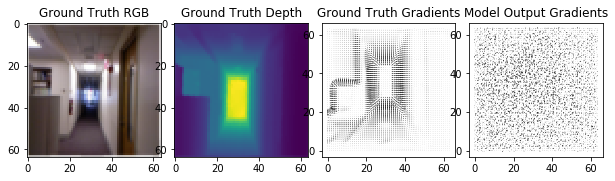

test_batch (Avg. Loss 0.036: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]
[I] - Saved checkpoint checkpoints/special_fusenet_overfit.pt at epoch 2


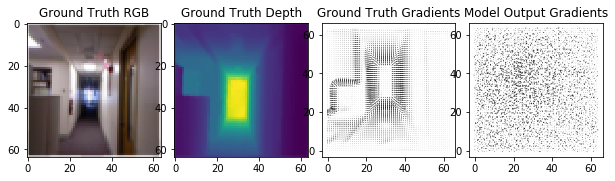

test_batch (Avg. Loss 0.034: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]
[I] - Saved checkpoint checkpoints/special_fusenet_overfit.pt at epoch 3


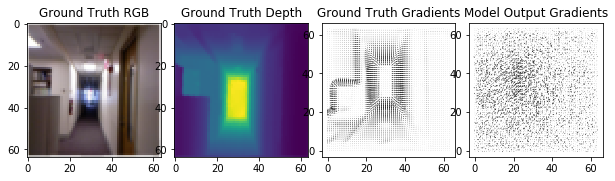

test_batch (Avg. Loss 0.033: 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]
[I] - Saved checkpoint checkpoints/special_fusenet_overfit.pt at epoch 4


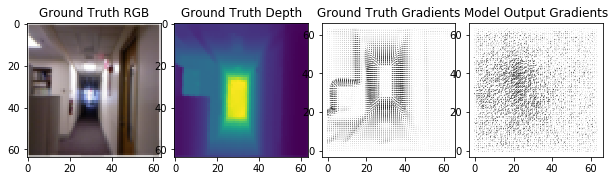

test_batch (Avg. Loss 0.031: 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]
[I] - Saved checkpoint checkpoints/special_fusenet_overfit.pt at epoch 5


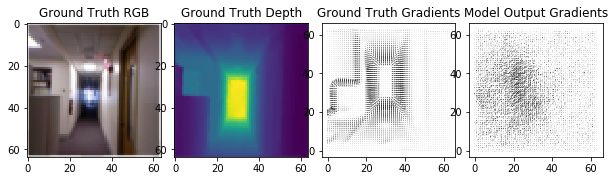

test_batch (Avg. Loss 0.029: 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]
[I] - Saved checkpoint checkpoints/special_fusenet_overfit.pt at epoch 6


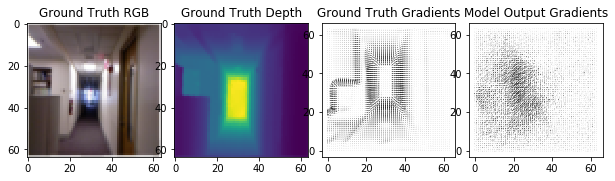

test_batch (Avg. Loss 0.028: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
[I] - Saved checkpoint checkpoints/special_fusenet_overfit.pt at epoch 7


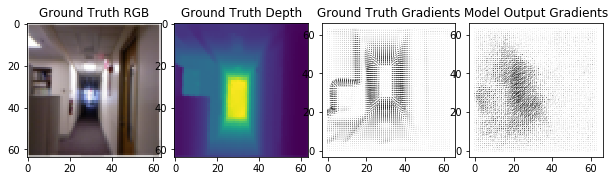

test_batch (Avg. Loss 0.026: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]
[I] - Saved checkpoint checkpoints/special_fusenet_overfit.pt at epoch 8


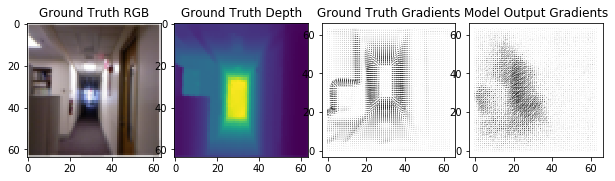

test_batch (Avg. Loss 0.024: 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]
[I] - Saved checkpoint checkpoints/special_fusenet_overfit.pt at epoch 9


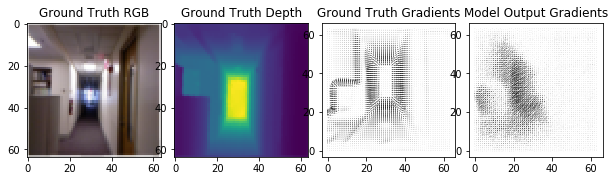

test_batch (Avg. Loss 0.023: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]
[I] - Saved checkpoint checkpoints/special_fusenet_overfit.pt at epoch 10


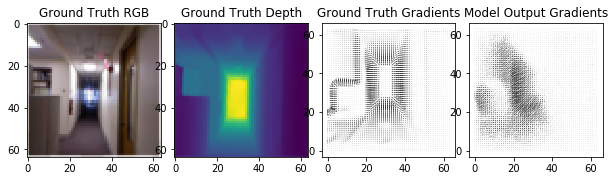

--- EPOCH 11/400 ---
test_batch (Avg. Loss 0.022: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]
[I] - Saved checkpoint checkpoints/special_fusenet_overfit.pt at epoch 11


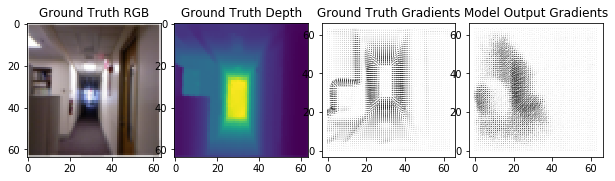

test_batch (Avg. Loss 0.021: 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]
[I] - Saved checkpoint checkpoints/special_fusenet_overfit.pt at epoch 12


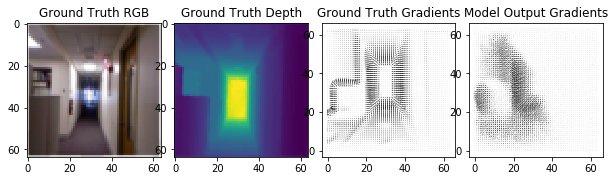

test_batch (Avg. Loss 0.020: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]
[I] - Saved checkpoint checkpoints/special_fusenet_overfit.pt at epoch 13


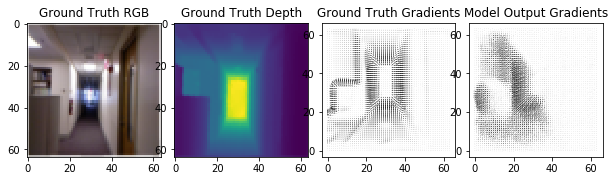

test_batch (Avg. Loss 0.019: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]
[I] - Saved checkpoint checkpoints/special_fusenet_overfit.pt at epoch 14


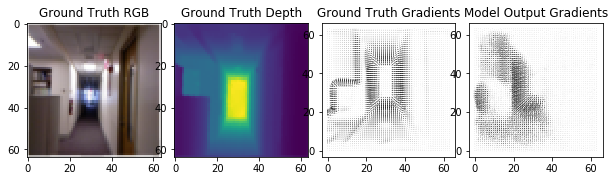

test_batch (Avg. Loss 0.017: 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]
[I] - Saved checkpoint checkpoints/special_fusenet_overfit.pt at epoch 15


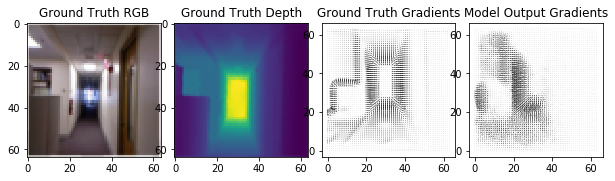

test_batch (Avg. Loss 0.016: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]
[I] - Saved checkpoint checkpoints/special_fusenet_overfit.pt at epoch 16


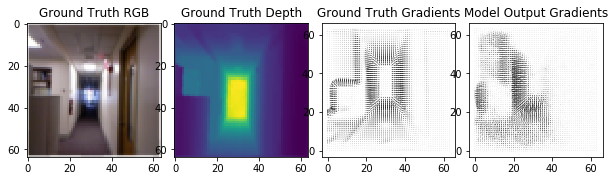

test_batch (Avg. Loss 0.014: 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]
[I] - Saved checkpoint checkpoints/special_fusenet_overfit.pt at epoch 17


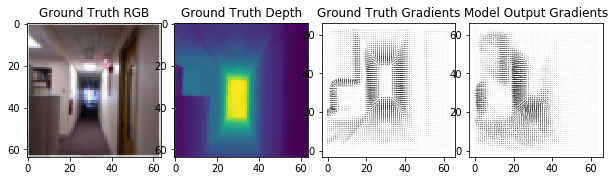

test_batch (Avg. Loss 0.013: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]
[I] - Saved checkpoint checkpoints/special_fusenet_overfit.pt at epoch 18


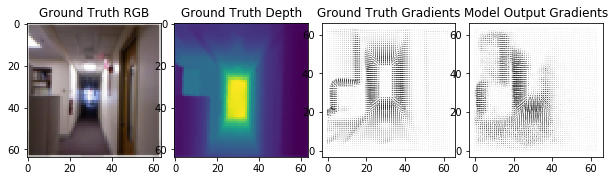

test_batch (Avg. Loss 0.012: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]
[I] - Saved checkpoint checkpoints/special_fusenet_overfit.pt at epoch 19


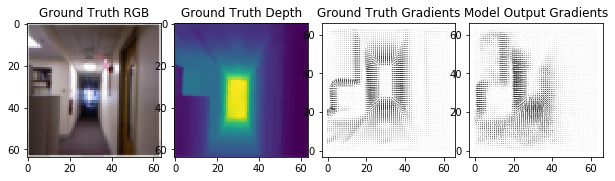

test_batch (Avg. Loss 0.011: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]
[I] - Saved checkpoint checkpoints/special_fusenet_overfit.pt at epoch 20


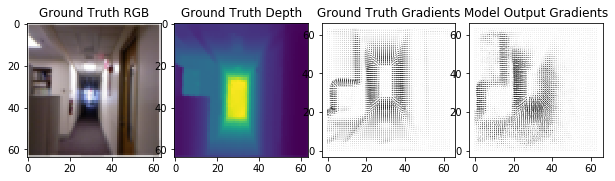

--- EPOCH 21/400 ---
train_batch:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
fit_res = trainer.fit(dl_train=dl_overfit, dl_test=dl_overfit, print_every=10, post_epoch_fn=post_epoch_plot, 
                     early_stopping=20, checkpoints=checkpoint_file)

In [ ]:
fit_res